In [0]:
# Import libraries
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
# Reading the diagnosis data
# diagnosisData = pd.read_csv("/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv", header=None)

diagnosisData = pd.read_csv("gdrive/My Drive/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv", header=None)
diagnosisData.columns= ["Patient No", "Disease"]

In [0]:
# Reading the demographic data
demographicData = pd.read_csv("gdrive/My Drive/demographic_info.txt", delimiter=" ", header=None)
demographicData.columns = ["Patient No", "Age", "Gender", "BMI for Adults", "Weight (Children)", "Height (Children)"]

# Calculating children BMI and adding that as a new column
demographicData['BMI for Children'] = demographicData.apply(lambda row: (row[4]/(row[5])**2)*10000, axis=1)
# Dropping the Height & Weight for Children columns as they are now replaced by BMI for Children
demographicData = demographicData.drop(['Weight (Children)', 'Height (Children)'], axis=1)
# Adding disease labels to demographic data
demographicData.insert(5, "Disease", diagnosisData.Disease)

In [0]:
# Combine Adult and Children BMI together in a new df: demographicSummary
combined = demographicData['BMI for Adults'].combine_first(demographicData['BMI for Children'])
demographicSummary = demographicData.copy()
demographicSummary.insert(3, "BMI", combined)
demographicSummary = demographicSummary.drop(["BMI for Adults", "BMI for Children"], axis=1)

In [6]:
# Review missing data in the demographic information
print(demographicSummary.isnull().sum())

Patient No    0
Age           1
Gender        1
BMI           9
Disease       0
dtype: int64


In [0]:
# Eliminate rows with at least three missing values
demographicSummary = demographicSummary.dropna(thresh=3)

In [8]:
# Review rows with remaining missing values
missing_BMI_indices = [i for i,v in enumerate(demographicSummary['BMI'].isnull()) if v==True]
print("Number of missing BMI data is", len(missing_BMI_indices))
missingData = demographicSummary.iloc[missing_BMI_indices]

Number of missing BMI data is 8


In [9]:
# Impute missing values for BMI based on the mean of similar rows
print(len(demographicSummary))
for index, row in missingData.iterrows():
    age = row[1]
    gender = row[2]
    disease = row[4]
    if demographicSummary[ (demographicSummary['Gender'] == gender)
                           & (demographicSummary['Disease'] == disease)
                           & (age - 5 <= demographicSummary['Age']) & (demographicSummary['Age'] <= age + 5) & (demographicSummary['BMI'].isnull()==False) ]['Patient No'].count()>=3:

        imputeFrom = demographicSummary[ (demographicSummary['Gender'] == gender)
                           & (demographicSummary['Disease'] == disease)
                           & (age - 5 <= demographicSummary['Age']) & (demographicSummary['Age'] <= age + 5) & (demographicSummary['BMI'].isnull()==False) ]
        mean = imputeFrom['BMI'].mean()
        demographicSummary.at[index, 'BMI'] = mean
    else:
        demographicSummary = demographicSummary.drop(index)
print(len(demographicSummary)) # row index 7 (pt 108) and 96 (pt 197) have been removed

125
123


In [0]:
# Reading annotation txt files
import glob
path = r'gdrive/My Drive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
all_files = glob.glob(path + "/*.txt")
def AnnotationData(filename, path):
    """
    For each filename in a given path, extracts the information from the file naming convention and reads the information
    within the file.
    Returns two dataframes: one with information on file naming, other with information from the file itself.
    """
    words = filename[len(path):-4].split('_')
    recording_info = pd.DataFrame(data = [words], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(filename, names = ['t_start', 't_end', 'Crackles', 'Wheezes'], delim_whitespace=True)
    return (recording_info, recording_annotations)

In [0]:
# Calling above function to read annotation files
infoList = []
for filename in all_files:
    (info, annotation) = AnnotationData(filename, path)
    # Number of crackles / wheezes for all respiratory cycles within each recording are summed
    crackles = annotation['Crackles'].sum()
    wheezes = annotation['Wheezes'].sum()
    # Summed number of crackles / wheezes are normalized by the duration of the recording
    duration = annotation.iloc[-1, 1] - annotation.iloc[0, 0]
    info['Crackles'] = crackles/duration # crackles per second
    info['Wheezes'] = wheezes/duration # wheezes per second
    infoList.append(info)

In [0]:
# Converting infoList to dataframe
info = pd.concat(infoList, axis = 0).sort_values(by="Patient number")
# As there are several recordings for some patients, the averages of normalized number of crackles and wheezes are taken for each patient
crackles_wheezes = info.iloc[:, [0,5,6]].groupby("Patient number").mean().reset_index()

In [0]:
# Combining crackles_wheezes with demographics summary data to input into Decision Tree
dem_crackles_wheezes = pd.concat([demographicSummary, crackles_wheezes.iloc[:,[1,2]]], axis=1, sort=False).dropna()

In [0]:
# Combining crackles_wheezes with demographics summary data to input into Decision Tree
dem_crackles_wheezes = pd.concat([demographicSummary, crackles_wheezes.iloc[:,[1,2]]], axis=1, sort=False).dropna()

In [16]:
dataset = dem_crackles_wheezes
print(dataset.head())

   Patient No    Age Gender        BMI  Disease  Crackles   Wheezes
0       101.0   3.00      F  19.385777     URTI  0.000000  0.000000
1       102.0   0.75      F  18.389942  Healthy  0.000000  0.000000
2       103.0  70.00      F  33.000000   Asthma  0.000000  0.203926
3       104.0  70.00      F  28.470000     COPD  0.009503  0.065145
4       105.0   7.00      F  17.558299     URTI  0.000000  0.000000


In [0]:
# Dropping asthma and LRTI cases as these have only 1 patient
dataset = dataset.drop(dataset[ (dataset.Disease == 'Asthma') | (dataset.Disease == 'LRTI') ].index).reset_index(drop=True)

In [0]:
X = dataset.iloc[:,[1,2,3,5,6]].values
y = dataset.iloc[:,4].values

In [0]:
# encoding categorical data e.g. gender as a dummy variable
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
X[:,1] = labelencoder_X.fit_transform(X[:,1])

# encoding categorical data e.g. disease outcome as a dummy variable
y,class_names = pd.factorize(y)

In [0]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state = 42)

In [21]:
# Fitting Classifier to the Training Set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=42)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [22]:
# Model performance on training set
y_pred_train =classifier.predict(X_train)

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

accuracy = metrics.accuracy_score(y_train, y_pred_train)
print("Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_train,y_pred_train)
print('Confusion Matrix: \n', cm)
print(classification_report(y_train, y_pred_train, target_names=class_names))

Accuracy: 0.83
Confusion Matrix: 
 [[ 0 10  0  0  0  0]
 [ 0 19  0  0  0  0]
 [ 0  0 47  0  0  0]
 [ 0  0  1  4  0  0]
 [ 0  1  3  0  0  0]
 [ 0  0  0  0  0  5]]
                precision    recall  f1-score   support

          URTI       0.00      0.00      0.00        10
       Healthy       0.63      1.00      0.78        19
          COPD       0.92      1.00      0.96        47
Bronchiectasis       1.00      0.80      0.89         5
     Pneumonia       0.00      0.00      0.00         4
 Bronchiolitis       1.00      1.00      1.00         5

      accuracy                           0.83        90
     macro avg       0.59      0.63      0.60        90
  weighted avg       0.73      0.83      0.77        90



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Predicting the test results
y_pred=classifier.predict(X_test)

# Classification results on test set
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))

from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_test,y_pred)
print('Confusion Matrix: \n', cm)
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy: 0.74
Confusion Matrix: 
 [[ 0  3  0  0  0  0]
 [ 0  7  0  0  0  0]
 [ 0  0 16  0  0  0]
 [ 0  0  2  0  0  0]
 [ 0  0  2  0  0  0]
 [ 0  1  0  0  0  0]]
                precision    recall  f1-score   support

          URTI       0.00      0.00      0.00         3
       Healthy       0.64      1.00      0.78         7
          COPD       0.80      1.00      0.89        16
Bronchiectasis       0.00      0.00      0.00         2
     Pneumonia       0.00      0.00      0.00         2
 Bronchiolitis       0.00      0.00      0.00         1

      accuracy                           0.74        31
     macro avg       0.24      0.33      0.28        31
  weighted avg       0.56      0.74      0.63        31



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


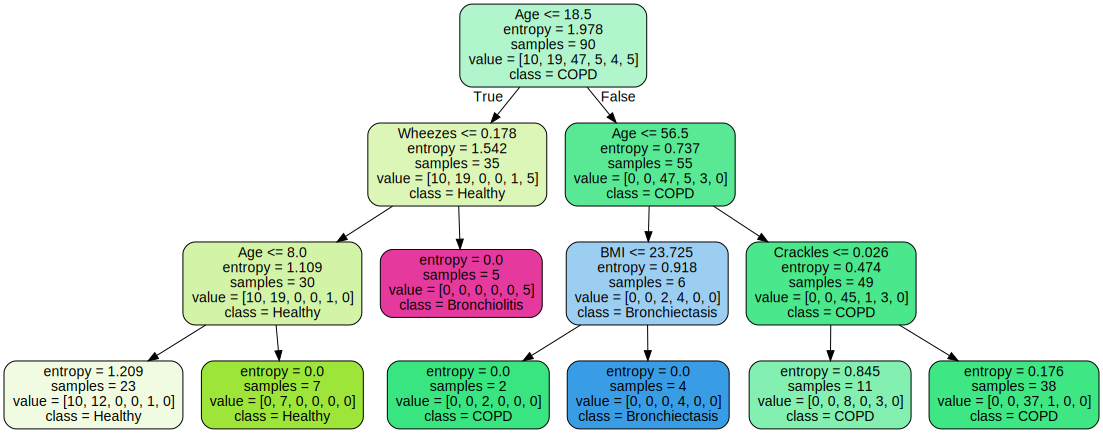

In [24]:
# Visualize the tree by graphiz
import graphviz
from sklearn import tree
feature_names = ['Age','Gender', 'BMI', 'Crackles', 'Wheezes']
dot_data = tree.export_graphviz(classifier, out_file=None, filled=True, rounded = True, feature_names=feature_names, class_names=class_names)
graph = graphviz.Source(dot_data)
graph